# Projet IMA - Segmentation de mélanomes 

In [12]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt
import copy
import scipy

Définissons une fonction OpenImage qui permet d'ouvrir l'image à partir du path et qui la met en noir et blanc


In [13]:
def OpenImage(filepath):
    img = cv2.imread(filepath)
    #print(img)
    img=img[:,:,0]
    #img=img[:,:,::-1]
    #plt.imshow(img)
    #plt.show()
    return img




Définissons maintenant une fonction qui permet de retirer le cadre noir autour d'une image, s'il exsite 

In [30]:
def Retirer_cadre(im):
    n=len(im)
    m=len(im[0])
    new_im=im.copy()
    for i in range(10):
        for j in range(m):
            new_im[i][j]=255
            new_im[n-1-i][j]=255
    for j in range(10):
        for i in range(n):
            new_im[i][j]=255
            new_im[i][m-1-j]=255
    for i in range(10,n//2):
        a=10
        while im[i][a]<175:
            new_im[i][a]=255
            a+=1
            if a<m-15:
                for k in range(12):
                    new_im[i][a]=255
                    a+=1
    for i in range(10,n//2):
        a=m-1-10
        while im[i][a]<175:
            new_im[i][a]=255
            a=a-1
            if a>15:
                for k in range(12):
                    new_im[i][a]=255
                    a=a-1
            
    
    for i in range(n//2,n-1):
        a=10
        while im[i][a]<175:
            new_im[i][a]=255
            a=a+1
            if a<m-15:
                for k in range(12):
                    new_im[i][a]=255
                    a+=1
    for i in range(n//2,n-1):
        a=m-1-10
        while im[i][a]<175:
            new_im[i][a]=255
            a=a-1
            if a>15:
                for k in range(12):
                    new_im[i][a]=255
                    a=a-1
    return new_im

Définissons maintenant une fonction AdjustIntensity qui permet d'augmenter le contraste en étalant les pixels sur l'ensemble de l'histogramme

In [26]:
def AdjustIntensity(im):
    im2 = im.flatten()
    im2.sort()
    onePercent = len(im2)//100
    petit = im2[onePercent]
    grand = im2[im2.shape[0] - onePercent]
    newIm = im.copy()
    (n, m) = (im.shape[0], im.shape[1])
    
    for i in range(0, n):
        for j in range(0, m):
            if (im[i][j] > grand):
                newIm[i][j] = 255
            elif (im[i][j]< petit):
                newIm[i][j] = 0
            else:
                newIm[i][j] = int((float(0 + (im[i][j] - petit) *255) / float(grand - petit)))

    return (newIm)

### Testons sur une image 

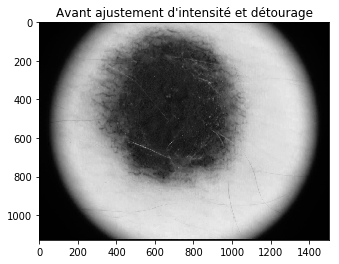

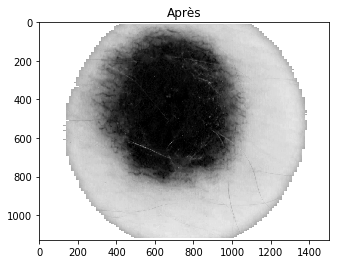

In [29]:
im=OpenImage("./nevus/ISIC_0000045.jpg")
plt.imshow(im,cmap='gray')
plt.title("Avant ajustement d'intensité et détourage")
plt.show()
im1=Retirer_cadre(im)
im2=AdjustIntensity(im1)
plt.imshow(im2, cmap='gray')
plt.title('Après')
plt.show()

On voit que le contraste a bien augmenté, ce qui était l'effet recherché.
De plus, on a bien une seule composante noire au milieu, ce qui sera utile au moment du seuillage. 



### Définissons maintenant la fonction Otsu
Celle-ci recherche le meilleur seuil possible et applique le seuillage à l'image

In [10]:
def otsu(im):
    hist,_ = np.histogram(im,range(0,256))
    Variance = np.zeros(256)         
    for k in range (0,256): 
        omega_1 = hist[0:k].sum().astype(float)
        omega_2 = hist[k:-1].sum().astype(float)
        m1 = np.mean(im[im<=k])
        if (np.isnan(m1)):
            m1 = 0
        m2 = np.mean(im[im>k])
        if (np.isnan(m2)):
            m2 = 0
        Variance[k] = omega_1 * omega_2 * ( (m1 - m2)**2)
    seuil = np.argmax(Variance)
    
    im3=im.copy()
    n=len(im)
    m=len(im[0])
    for i in range(n):
        for j in range(m):
            if im[i][j]>seuil:
                im3[i][j]=0
            else:
                im3[i][j]=255
    return im3
         

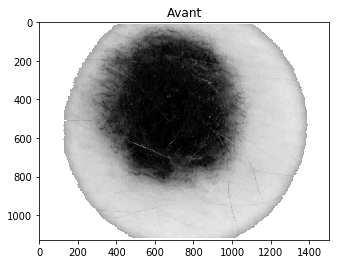

/home/paul/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paul/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


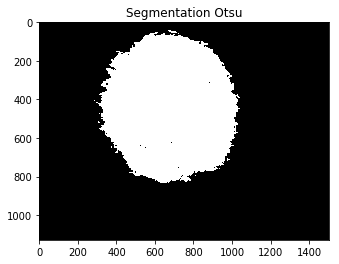

In [11]:
plt.imshow(im2,cmap='gray')
plt.title("Avant")
plt.show()
im3=otsu(im2)
plt.imshow(im3,cmap='gray')
plt.title("Segmentation Otsu")
plt.show()


Reste à effectuer une dilatation pour combler les trous blancs et ainsi obtenir notre composante connexe.

In [18]:
def dilatation_carrée(im,taille):
    t=taille//2
    n=len(im)
    m=len(im[0])
    im1=im.copy()
    for i in range(taille,n-taille):
        for j in range(taille,m-taille):
            for a in range(i-t,i+t):
                for b in range(j-t,j+t):
                    if im[a][b]==0:
                        for a in range(i-t,i+t):
                            for b in range(j-t,j+t):
                                im1[a][b]=0
                    break; 
                break; 
    return im1

def erosion_carrée(im,taille):
    t=taille//2
    n=len(im)
    m=len(im[0])
    im1=im.copy()
    for i in range(taille,n-taille):
        for j in range(taille,m-taille):
            for a in range(i-t,i+t):
                for b in range(j-t,j+t):
                    if im[a][b]==255:
                        for a in range(i-t,i+t):
                            for b in range(j-t,j+t):
                                im1[a][b]=255
                    break; 
                break; 
    return im1

    
        

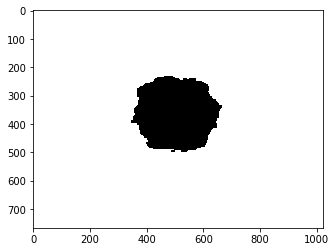

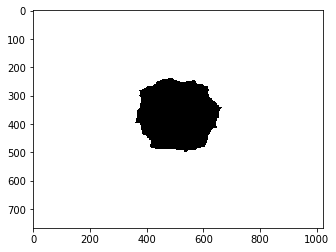

In [50]:
im4=dilatation_carrée(im3,11)
plt.imshow(im4,cmap='gray')
plt.show()
im5=erosion_carrée(im4,11)
plt.imshow(im5,cmap='gray')
plt.show()

A PARTIR DE LA C'EST QUE DU TEST QUI MARCHE PAS 

In [21]:
def Retirer_le_cadre_image(im,pas):
    n=len(im)
    m=len(im[0])
    taille_min=(min(n,m)//2)-2
    xm=n//2
    ym=m//2
    avancee=1
    moyenne=0
    cpt=0
    while(moyenne<10 and avancee<taille_min):
        avancee=avancee+1
        for i in range(ym-avancee*pas,ym+avancee*pas):
            for j in range(xm-avancee*pas,xm+avancee*pas):
                moyenne+=im[i][j]
                cpt+=1
        moyenne=moyenne/cpt
    return avancee*pas

In [ ]:
Retirer_le_cadre_image(im3,10)

C'est beaucoup trop faible... On va tester autre chose 

In [ ]:
def estFaux(tab):
    for i in tab:
        if i==True:
            return False
        return True


def retirer(im,pas):
    n=len(im)
    m=len(im[0])
    taille_min=(min(n,m)//2)-2
    xm=n//2
    ym=m//2
    tab=[True,True,True,True]
    avancee=1
    while(not(estFaux(tab))):
        avancee=avancee+1
        if im[xm][ym+avancee*pas]==255:
            tab[0]=False
        if im[xm][ym-avancee*pas]==255:
            tab[1]=False
        if im[xm+avancee*pas][ym]==255:
            tab[2]=False
        if im[xm-avancee*pas][ym]==255:
            tab[3]=False
    return im[xm-avancee*pas:xm+avancee*pas,ym-avancee*pas:ym+avancee*pas]
            
        
        
        

In [ ]:
retirer(im3,10)

In [ ]:
im4=retirer(im3,10)
plt.imshow(im4,cmap='gray')
plt.show()

In [ ]:
def circle(im, r):
    n=len(im[0])
    m=len(im)
    xm=n//2
    ym=m//2
    somme = 0
    card = 0
    for x in range(n):
        for y in range(m):
            if ((x-xm)**2 + (y-ym)**2 >= r**2) :
                somme += im[y][x]
                card += 1       
    return somme/card

In [ ]:
def rayon(im):
    n=len(im[0])
    m=len(im)
    rmin=n//4
    rmax=(1/2)*sqrt(n**2 + m**2)
    nb_pas = 10
    pas=(rmax-rmin)/nb_pas
    Lrayon = []
    Lmoyenne = []
    r = rmin 
    for i in range (nb_pas) : 
        Lrayon.append(r)
        Lmoyenne.append(circle(im,r))
        r += pas
    return [Lrayon, Lmoyenne]

In [ ]:
def minMoyenne(im):   
    Lrayon, Lmoyenne = rayon(im)
    Mmin = 256
    indice = -1
    for i in range (len(Lrayon)):
        if Lmoyenne[i] > Mmin : 
            Mmin = Lmoyenne[i]
            indice = i
    return indice+4

In [ ]:
def nouvelleImage(im):
    n=len(im[0])
    m=len(im)
    xm=n//2
    ym=m//2
    return (im[xm-minMoyenne(im):xm+minMoyenne(im),ym-minMoyenne(im):ym+minMoyenne(im)])


In [39]:
kernel=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

In [52]:
def contours(im):
    n=len(im)
    m=len(im[0])
    new_im=im.copy()
    for i in range(1,n-1):
        for j in range(1,m-1):
            new_im[i][j]=4*im[i][j]-im[i+1][j]-im[i-1][j]-im[i][j+1]-im[i][j-1]
    return new_im
    

In [53]:
im6=contours(im5)

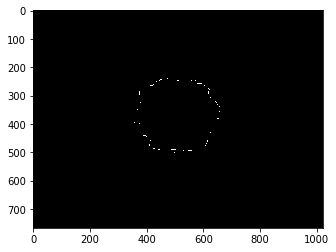

In [54]:
plt.imshow(im6,cmap='gray')

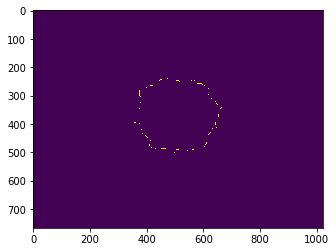

In [55]:
edges = cv2.Canny(im5,0,0)
plt.imshow(edges)

In [6]:
import skimage

from skimage import feature
M = np.zeros((im5.shape[0],im5.shape[1]))

M[:,:] = im5[:,:]
edges = feature.canny(M, sigma=1)

ModuleNotFoundError: No module named 'skimage'